In [1]:
import sys
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs

XML_EXT = '.xml'
ENCODE_METHOD = 'utf-8'

class PascalVocWriter:

    def __init__(self, foldername, filename, imgSize,databaseSrc='Unknown', localImgPath=None):
        self.foldername = foldername
        self.filename = filename
        self.databaseSrc = databaseSrc
        self.imgSize = imgSize
        self.boxlist = []
        self.localImgPath = localImgPath
        self.verified = False

    def prettify(self, elem):
        """
            Return a pretty-printed XML string for the Element.
        """
        rough_string = ElementTree.tostring(elem, 'utf8')
        root = etree.fromstring(rough_string)
        return etree.tostring(root, pretty_print=True, encoding=ENCODE_METHOD).replace("  ".encode(), "\t".encode())
        # minidom does not support UTF-8
        '''reparsed = minidom.parseString(rough_string)
        return reparsed.toprettyxml(indent="\t", encoding=ENCODE_METHOD)'''

    def genXML(self):
        """
            Return XML root
        """
        # Check conditions
        if self.filename is None or \
                self.foldername is None or \
                self.imgSize is None:
            return None

        top = Element('annotation')
        if self.verified:
            top.set('verified', 'yes')

        folder = SubElement(top, 'folder')
        folder.text = self.foldername

        filename = SubElement(top, 'filename')
        filename.text = self.filename

        if self.localImgPath is not None:
            localImgPath = SubElement(top, 'path')
            localImgPath.text = self.localImgPath

        source = SubElement(top, 'source')
        database = SubElement(source, 'database')
        database.text = self.databaseSrc

        size_part = SubElement(top, 'size')
        width = SubElement(size_part, 'width')
        height = SubElement(size_part, 'height')
        depth = SubElement(size_part, 'depth')
        width.text = str(self.imgSize[1])
        height.text = str(self.imgSize[0])
        if len(self.imgSize) == 3:
            depth.text = str(self.imgSize[2])
        else:
            depth.text = '1'

        segmented = SubElement(top, 'segmented')
        segmented.text = '0'
        return top

    def addBndBox(self, xmin, ymin, xmax, ymax, name, difficult):
        bndbox = {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
        bndbox['name'] = name
        bndbox['difficult'] = difficult
        self.boxlist.append(bndbox)

    

    def appendObjects(self, top):
        for each_object in self.boxlist:
            object_item = SubElement(top, 'object')
            name = SubElement(object_item, 'name')
            try:
                name.text = unicode(each_object['name'])
            except NameError:
                # Py3: NameError: name 'unicode' is not defined
                name.text = each_object['name']
            pose = SubElement(object_item, 'pose')
            pose.text = "Unspecified"
            truncated = SubElement(object_item, 'truncated')
            if int(each_object['ymax']) == int(self.imgSize[0]) or (int(each_object['ymin'])== 1):
                truncated.text = "1" # max == height or min
            elif (int(each_object['xmax'])==int(self.imgSize[1])) or (int(each_object['xmin'])== 1):
                truncated.text = "1" # max == width or min
            else:
                truncated.text = "0"
            difficult = SubElement(object_item, 'difficult')
            difficult.text = str( bool(each_object['difficult']) & 1 )
            bndbox = SubElement(object_item, 'bndbox')
            xmin = SubElement(bndbox, 'xmin')
            xmin.text = str(each_object['xmin'])
            ymin = SubElement(bndbox, 'ymin')
            ymin.text = str(each_object['ymin'])
            xmax = SubElement(bndbox, 'xmax')
            xmax.text = str(each_object['xmax'])
            ymax = SubElement(bndbox, 'ymax')
            ymax.text = str(each_object['ymax'])

    def save(self, targetFile=None):
        root = self.genXML()
        self.appendObjects(root)
        out_file = None
        if targetFile is None:
            out_file = codecs.open(
                self.filename + XML_EXT, 'w', encoding=ENCODE_METHOD)
        else:
            out_file = codecs.open(targetFile, 'w', encoding=ENCODE_METHOD)

        prettifyResult = self.prettify(root)
        out_file.write(prettifyResult.decode('utf8'))
        out_file.close()


class PascalVocReader:

    def __init__(self, filepath):
        # shapes type:
        # [labbel, [(x1,y1), (x2,y2), (x3,y3), (x4,y4)], color, color, difficult]
        self.shapes = []
        self.filepath = filepath
        self.verified = False
        try:
            self.parseXML()
        except:
            pass

    def getShapes(self):
        return self.shapes

    def addShape(self, label, bndbox, difficult):
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        points = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
        self.shapes.append((label, points, None, None, difficult))

    def parseXML(self):
        assert self.filepath.endswith(XML_EXT), "Unsupport file format"
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xmltree = ElementTree.parse(self.filepath, parser=parser).getroot()
        filename = xmltree.find('filename').text
        try:
            verified = xmltree.attrib['verified']
            if verified == 'yes':
                self.verified = True
        except KeyError:
            self.verified = False

        for object_iter in xmltree.findall('object'):
            bndbox = object_iter.find("bndbox")
            label = object_iter.find('name').text
            # Add chris
            difficult = False
            if object_iter.find('difficult') is not None:
                difficult = bool(int(object_iter.find('difficult').text))
            self.addShape(label, bndbox, difficult)
        return True


In [2]:
import os
import sys
import unittest

class TestPascalVocRW(unittest.TestCase):

    def test_upper(self):
        dir_name = os.path.abspath(os.path.dirname(__file__))
        libs_path = os.path.join(dir_name, '..', 'libs')
        sys.path.insert(0, libs_path)
        from pascal_voc_io import PascalVocWriter
        from pascal_voc_io import PascalVocReader

        # Test Write/Read
        writer = PascalVocWriter('tests', 'test', (512, 512, 1), localImgPath='tests/test.bmp')
        difficult = 1
        writer.addBndBox(60, 40, 430, 504, 'person', difficult)
        writer.addBndBox(113, 40, 450, 403, 'face', difficult)
        writer.save('tests/test.xml')

        reader = PascalVocReader('tests/test.xml')
        shapes = reader.getShapes()

        personBndBox = shapes[0]
        face = shapes[1]
        self.assertEqual(personBndBox[0], 'person')
        self.assertEqual(personBndBox[1], [(60, 40), (430, 40), (430, 504), (60, 504)])
        self.assertEqual(face[0], 'face')
        self.assertEqual(face[1], [(113, 40), (450, 40), (450, 403), (113, 403)])

if __name__ == '__main__':
    unittest.main()

E
ERROR: /Users/jerry/Library/Jupyter/runtime/kernel-e71d9b01-046a-4904-a959-cc327f4b381e (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/Users/jerry/Library/Jupyter/runtime/kernel-e71d9b01-046a-4904-a959-cc327f4b381e'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

/anaconda3/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
from lxml import etree

In [20]:
root = etree.Element("root")

In [21]:
print(root.tag)

root


In [22]:
root.append(etree.Element('child1'))

In [23]:
child2 = etree.SubElement(root, "child2")
child3 = etree.SubElement(root, "child3")

In [24]:
print(etree.tostring(root, pretty_print=True).decode('utf-8'))

<root>
  <child1/>
  <child2/>
  <child3/>
</root>



In [25]:
child = root[0]
print(child.tag)

child1


In [26]:
print(len(root))

3


In [27]:
root.index(root[1])

1

In [29]:
children = list(root)
children

[<Element child1 at 0x1090995c8>,
 <Element child2 at 0x109099748>,
 <Element child3 at 0x109079f08>]

In [30]:
for child in root:
    print(child.tag)

child1
child2
child3


In [31]:
root.insert(0, etree.Element("child0"))

In [32]:
print(etree.tostring(root, pretty_print=True).decode('utf-8'))

<root>
  <child0/>
  <child1/>
  <child2/>
  <child3/>
</root>



In [33]:
start = root[:1]
end = root[-1:]
print(start[0].tag)
print(end[0].tag)

child0
child3


In [34]:
if root:   # this no longer works!
    print("The root element has children")

The root element has children


/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  """Entry point for launching an IPython kernel.


In [35]:
etree.iselement(root)

True

In [36]:
if len(root):
    print("The root element has children")

The root element has children


In [38]:
print(etree.tostring(root, pretty_print=True).decode('utf-8'))

root[0] = root[-1]

print(etree.tostring(root, pretty_print=True).decode('utf-8'))

<root>
  <child0/>
  <child1/>
  <child2/>
  <child3/>
</root>

<root>
  <child3/>
  <child1/>
  <child2/>
</root>



In [39]:
root is root[0].getparent()

True

In [40]:
from copy import deepcopy
element = etree.Element("neu")
element.append( deepcopy(root[1]) )
print(element[0].tag)
print([c.tag for c in root])

child1
['child3', 'child1', 'child2']


In [47]:
row = [1,2,3,4,5,6]
iterrow = iter(row)
[(i,j) for i,j in (iterrow(),iterrow())]

TypeError: 'list_iterator' object is not callable

In [48]:
print("str",1)

str 1


In [89]:
import sys
import os
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
# from lxml.etree import ElementTree, Element, SubElement
from lxml import etree
import codecs
from libs.shapeType import shapeTypes

XML_EXT = '.xml'
ENCODE_METHOD = 'utf-8'

class PascalVocWriter:

    def __init__(self, foldername, filename, imgSize,databaseSrc='Unknown', localImgPath=None):
        self.foldername = foldername
        self.filename = filename
        self.databaseSrc = databaseSrc
        self.imgSize = imgSize
        self.shapelist = []
        self.localImgPath = localImgPath
        self.verified = False

    def prettify(self, elem):
        """
            Return a pretty-printed XML string for the Element.
        """
        rough_string = ElementTree.tostring(elem, 'utf8')
        root = etree.fromstring(rough_string)
        return etree.tostring(root, pretty_print=True, encoding=ENCODE_METHOD).replace("  ".encode(), "\t".encode())
        # minidom does not support UTF-8
        '''reparsed = minidom.parseString(rough_string)
        return reparsed.toprettyxml(indent="\t", encoding=ENCODE_METHOD)'''

    def genXML(self):
        """
            Return XML root
        """
        # Check conditions
        if self.filename is None or \
                self.foldername is None or \
                self.imgSize is None:
            return None

        top = Element('annotation')
        if self.verified:
            top.set('verified', 'yes')

        folder = SubElement(top, 'folder')
        folder.text = self.foldername

        filename = SubElement(top, 'filename')
        filename.text = self.filename

        if self.localImgPath is not None:
            localImgPath = SubElement(top, 'path')
            localImgPath.text = self.localImgPath

        source = SubElement(top, 'source')
        database = SubElement(source, 'database')
        database.text = self.databaseSrc

        size_part = SubElement(top, 'size')
        width = SubElement(size_part, 'width')
        height = SubElement(size_part, 'height')
        depth = SubElement(size_part, 'depth')
        width.text = str(self.imgSize[1])
        height.text = str(self.imgSize[0])
        if len(self.imgSize) == 3:
            depth.text = str(self.imgSize[2])
        else:
            depth.text = '1'

        segmented = SubElement(top, 'segmented')
        segmented.text = '0'
        return top

    def addShape(self, shapeType, points, label, difficult):
        # def convert(shapeType, points):
        #     if shapeType == shapeTypes.
        shape = {'shapeType': shapeType, 
                 'points': points,
                 'label': label,
                 'difficult': difficult}
        self.shapelist.append(shape)


    def appendObjects(self, top):
        for each_object in self.shapelist:
            each_shapeType = each_object['shapeType']
            each_points = each_object['points']
            each_label = each_object['label']
            each_difficult = each_object['difficult']

            object_item = SubElement(top, 'object')
            shapeType_subitem = SubElement(object_item, 'shapeType')
            shapeType_subitem.text = str(each_shapeType)
            label_subitem = SubElement(object_item, 'label')
            try:
                label_subitem.text = unicode(each_object['label'])
            except NameError:
                # Py3: NameError: name 'unicode' is not defined
                label_subitem.text = each_object['label']
                
            pose = SubElement(object_item, 'pose')
            pose.text = "Unspecified"
            truncated = SubElement(object_item, 'truncated')
            xmin = ymin = float('inf')
            xmax = ymax = float('-inf')
            for p in each_points:
                xmin = p[0] if p[0] < xmin else xmin
                ymin = p[1] if p[1] < ymin else ymin
                xmax = p[0] if p[0] > xmax else xmax
                ymax = p[1] if p[1] > ymax else ymax
            if (int(ymax) >= int(self.imgSize[0])) or (int(ymin) <= 1):
                truncated.text = "1" # max == height or min
            elif (int(xmax) >= int(self.imgSize[1])) or (int(xmin) <= 1):
                truncated.text = "1" # max == width or min
            else:
                truncated.text = "0"
                
            difficult = SubElement(object_item, 'difficult')
            difficult.text = str( bool(each_object['difficult']) & 1 )
            
            points_subitem = SubElement(object_item,"points")
            for i, pt in enumerate(each_points):
                point_subsubitem = SubElement(points_subitem, "point")
                X = SubElement(point_subsubitem,"X")
                X.text = str(pt[0])
                Y = SubElement(point_subsubitem,"Y")
                Y.text = str(pt[1])

    def save(self, targetFile=None):
        root = self.genXML()
        self.appendObjects(root)
        out_file = None
        if targetFile is None:
            out_file = codecs.open(
                self.filename + XML_EXT, 'w', encoding=ENCODE_METHOD)
        else:
            out_file = codecs.open(targetFile, 'w', encoding=ENCODE_METHOD)

        prettifyResult = self.prettify(root)
        out_file.write(prettifyResult.decode('utf8'))
        out_file.close()


class PascalVocReader:

    def __init__(self, filepath):
        # shapes type:
        # [shapeType, label, 
        #  [(x1,y1), (x2,y2), (x3,y3), (x4,y4)], 
        #  color, color, 
        #  difficult]
        self.shapes = []
        self.filepath = filepath

        self.verified = False
        try:
            self.parseXML()
        except:
            pass

    def getShapes(self):
        return self.shapes

    def addShape(self, shapeType, label, points, difficult):
        # xmin = int(bndbox.find('xmin').text)
        # ymin = int(bndbox.find('ymin').text)
        # xmax = int(bndbox.find('xmax').text)
        # ymax = int(bndbox.find('ymax').text)
        # points = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
        self.shapes.append((shapeType, label, points, None, None, difficult))

    def parseXML(self):
        assert self.filepath.endswith(XML_EXT), "Unsupport file format"
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xmltree = ElementTree.parse(self.filepath, parser=parser).getroot()
        filename = xmltree.find('filename').text
        try:
            verified = xmltree.attrib['verified']
            if verified == 'yes':
                self.verified = True
        except KeyError:
            self.verified = False

        for object_iter in xmltree.findall('object'):
            shapeType = object_iter.find("shapeType").text
            print(shapeType)
            points_item = object_iter.find("points")
            points = [(int(float(point[0].text)), int(float(point[1].text))) for point in points_item]

            label = object_iter.find('label').text
            # Add chris
            difficult = False
            if object_iter.find('difficult') is not None:
                difficult = bool(int(object_iter.find('difficult').text))
            self.addShape(shapeType, label, points, difficult)
        return True



In [90]:
foldername = os.curdir
filename = 'test.xml'
imgSize = (800, 1000)


In [91]:
writer = PascalVocWriter(foldername, filename, imgSize)

In [92]:
writer.addShape(shapeTypes.box, [(1,2),(3,4)], "break", "difficult")
writer.addShape(shapeTypes.polygon, [(1,2),(3,4),(5,6),(7,8),(9,10)], "intact", "difficult")
writer.addShape(shapeTypes.ellipse, [(1,2),(3,4),(5,6),(7,8)], "box", "difficult")


In [93]:
writer.save()

In [94]:
reader = PascalVocReader(os.path.join(foldername, filename))

box
polygon
ellipse


In [95]:
reader.getShapes()

[('box', 'break', [(1, 2), (3, 4)], None, None, True),
 ('polygon',
  'intact',
  [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)],
  None,
  None,
  True),
 ('ellipse', 'box', [(1, 2), (3, 4), (5, 6), (7, 8)], None, None, True)]

In [75]:
from lxml.etree import ElementTree, Element, SubElement
from lxml import etree

In [76]:
pointlist = [(1,2),
             (3,4),
             (5,6),
             (7,8),
             (9,10)]

In [77]:
top = Element('annotation')
for i, each_object in enumerate(pointlist):
    point = SubElement(top, "point"+str(i).zfill(3))
    X = SubElement(point,"X")
    X.text = str(each_object[0])
    Y = SubElement(point,"Y")
    Y.text = str(each_object[1])
print(etree.tostring(top, pretty_print=True).decode('utf-8'))

<annotation>
  <point000>
    <X>1</X>
    <Y>2</Y>
  </point000>
  <point001>
    <X>3</X>
    <Y>4</Y>
  </point001>
  <point002>
    <X>5</X>
    <Y>6</Y>
  </point002>
  <point003>
    <X>7</X>
    <Y>8</Y>
  </point003>
  <point004>
    <X>9</X>
    <Y>10</Y>
  </point004>
</annotation>



In [ ]:
for each_object in self.shapelist:
    object_item = SubElement(top, 'object')
    name = SubElement(object_item, 'name')
    try:
        name.text = unicode(each_object['name'])
    except NameError:
        # Py3: NameError: name 'unicode' is not defined
        name.text = each_object['name']

    pose = SubElement(object_item, 'pose')
    pose.text = "Unspecified"
    truncated = SubElement(object_item, 'truncated')
    if int(each_object['ymax']) == int(self.imgSize[0]) or (int(each_object['ymin'])== 1):
        truncated.text = "1" # max == height or min
    elif (int(each_object['xmax'])==int(self.imgSize[1])) or (int(each_object['xmin'])== 1):
        truncated.text = "1" # max == width or min
    else:
        truncated.text = "0"
    difficult = SubElement(object_item, 'difficult')
    difficult.text = str( bool(each_object['difficult']) & 1 )
    bndbox = SubElement(object_item, 'bndbox')
    xmin = SubElement(bndbox, 'xmin')
    xmin.text = str(each_object['xmin'])
    ymin = SubElement(bndbox, 'ymin')
    ymin.text = str(each_object['ymin'])
    xmax = SubElement(bndbox, 'xmax')
    xmax.text = str(each_object['xmax'])
    ymax = SubElement(bndbox, 'ymax')
    ymax.text = str(each_object['ymax'])

In [98]:
from PyQt5.QtGui import QImageReader

In [100]:
formats = ['*.%s' % fmt.data().decode("ascii").lower() for fmt in QImageReader.supportedImageFormats()]
formats

['*.bmp',
 '*.cur',
 '*.gif',
 '*.heic',
 '*.heif',
 '*.icns',
 '*.ico',
 '*.jp2',
 '*.jpeg',
 '*.jpg',
 '*.pbm',
 '*.pgm',
 '*.png',
 '*.ppm',
 '*.svg',
 '*.svgz',
 '*.tga',
 '*.tif',
 '*.tiff',
 '*.wbmp',
 '*.webp',
 '*.xbm',
 '*.xpm']

In [ ]:
class cache(object):
    def __init__(self, folderpath, filename, num = 1000):
        # 
        self.folder = path = os.path.dirname(ustr(self.filePath)) if self.filePath else '.'
        self.total
        pass

    def update(self):

    def openFile(self, _value=False):
        
        formats = ['*.%s' % fmt.data().decode("ascii").lower() for fmt in QImageReader.supportedImageFormats()]
        filters = "Image & Label files (%s)" % ' '.join(formats + ['*%s' % LabelFile.suffix])
        filename = QFileDialog.getOpenFileName(self, '%s - Choose Image or Label file' % __appname__, path, filters)
        if filename:
            if isinstance(filename, (tuple, list)):
                filename = filename[0]
            self.loadFile(filename)

    def prev(self, _value=False):
        # Proceding prev image without dialog if having any label
        if self.autoSaving.isChecked():
            if self.defaultSaveDir is not None:
                if self.dirty is True:
                    self.saveFile()
            else:
                self.changeSavedirDialog()
                return

        if not self.mayContinue():
            return

        if len(self.mImgList) <= 0:
            return

        if self.filePath is None:
            return

        currIndex = self.mImgList.index(self.filePath)
        if currIndex - 1 >= 0:
            filename = self.mImgList[currIndex - 1]
            if filename:
                self.loadFile(filename)

    def openNextImg(self, _value=False):
        # Proceding prev image without dialog if having any label
        if self.autoSaving.isChecked():
            if self.defaultSaveDir is not None:
                if self.dirty is True:
                    self.saveFile()
            else:
                self.changeSavedirDialog()
                return

        if not self.mayContinue():
            return

        if len(self.mImgList) <= 0:
            return

        filename = None
        if self.filePath is None:
            filename = self.mImgList[0]
        else:
            currIndex = self.mImgList.index(self.filePath)
            if currIndex + 1 < len(self.mImgList):
                filename = self.mImgList[currIndex + 1]

        if filename:
            self.loadFile(filename)

In [101]:
import math

In [103]:
math.floor(-0.1)

-1

In [105]:
from PyQt5.QtGui import QImage 

In [108]:
image = QImage()
image.load("/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg")
image

In [111]:
alist = [1,2,3,4,5]

In [113]:
flag = alist.index(0)
flag

ValueError: 0 is not in list

In [194]:
from PyQt5.QtGui import QImage

In [195]:
filename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg"
with open(filename, 'rb') as f:
    imageData = f.read()
image = QImage.fromData(imageData)

In [196]:
image.format()

4

In [199]:
image.Format_RGB32

4

In [135]:
image.width()

1072

In [136]:
image.height()

800

In [138]:
image.depth()

32

In [129]:
import qimage2ndarray
import numpy as np
import cv2
import matplotlib.pyplot as plt
# cv2.

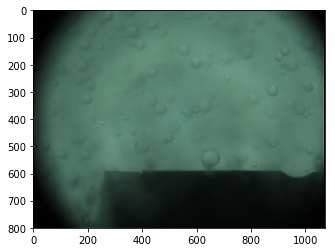

In [134]:
plt.imshow((qimage2ndarray.rgb_view(image)).reshape(800,1072,3))
plt.show()

In [222]:
import cv2

In [223]:
filename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg"
cvimg = cv2.imread(filename)

In [221]:
cvimg.shape

(800, 1072, 3)

In [224]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from PyQt5.QtCore import pyqtSignal
import numpy as np

# background subtraction and other preprossing procedure
FILENAME = "background.jpg"

class Preprocess:
    preprocessed = pyqtSignal()

    def __init__(self, dirname, length=10):
        if os.path.isdir(dirname):
            self.dirname = dirname
        else:
            return None
        self.imgPathList = glob.glob(os.path.join(self.dirname,'*.jpg'))
        tmp_img = cv2.imread(self.imgPathList[0])
        height, width, depth = tmp.img
        self.bg = np.zeros((height, width, depth))
        self.imgList = []
        self.length = length

    def __call__(self):
        img_path = os.path.join(self.dirname, FILENAME)
        # if we process it before and there exists backgrounnd image.
        if os.path.exists(img_path):
            self.bg = cv2.imread(img_path)
        else:
            self.imgPathList
            for index, f in enumerate(paths):
                if index >= self.length:
                    self.bg /= self.length
                    break
                img = cv2.imread(f)
                self.bg = np.add(self.bg, img)





NameError: name 'bgimg_gray' is not defined

In [ ]:
plt.imshow(bgimg_gray)

In [158]:
def qimage2numpyarray(image):
    height = image.height()
    width  = image.width()
    return (qimage2ndarray.rgb_view(image)).reshape(height, width, 3)

In [160]:
arr = qimage2numpyarray(image)
arr

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [191]:
def numpyarray2qimage(arr):
    # height = self.numpyarray.shape[1]
    # width  = self.numpyarray.shape[0]
    numpyarray = np.transpose(arr, (1,0,2))                                                                                                                                                                              
    return QImage(arr.tobytes(), 800, 1072,  6400, QImage.Format_RGB888)

In [192]:
qimage2numpyarray(numpyarray2qimage(arr))

ValueError: qimageview can only handle 8- or 32-bit QImages (format was 13)

In [ ]:
def getCurrent(self):
    if self.subtractBackGround:
        return self.numpyarray2qimage(\
                    np.subtract(self.qimage2numpyarray(self.data[self.cursor]) \
                    ,self.background))
    else:
        return self.data[self.cursor]

def qimage2numpyarray(self, imgdata):
    height = self.data[0].height()
    width  = self.data[0].width()
    return (qimage2ndarray.rgb_view(imgdata)).reshape(height, width, 3)

def numpyarray2qimage(self, numpyarray):
    # height = self.numpyarray.shape[1]
    # width  = self.numpyarray.shape[0]
    numpyarray = np.transpose(numpyarray, (1,0,2))                                                                                                                                                                              
    return QImage(numpyarray.tobytes(), numpyarray.shape[1], numpyarray.shape[0], QImage.Format_RGB888)


In [145]:
im_np

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ..., 
       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=int8)

In [152]:
im_np*100

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ..., 
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ..., 
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ..., 
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       ..., 
       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ..., 
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ..., 
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ..., 
        [100, 100, 100],
        [100, 100, 100],
        [100, 100,

In [153]:
im_np / 3

array([[[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        ..., 
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]],

       [[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        ..., 
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]],

       [[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        ..., 
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]],

       ..., 
       [[ 0.33333333,  0.33333333,  0.33333333],
        

In [155]:
np.array(im_np / 3,dtype=int)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [110]:
ims = []
cal = []
cal_gray = []
paths = glob.glob('data/600V350Q401/*.jpg')
step = 1
image = cv.imread(paths[0])
bgimg_gray = np.zeros((800, 1072))
# print(type(bgimg_gray))
# print(bgimg_gray.shape)
for index, f in zip(range(len(paths)-1), paths[::step]):
    if index >= step + 1000:
        bgimg_gray /= index
        break
    image = cv.imread(f)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    bgimg_gray = np.add(bgimg_gray, image_gray)
    
plt.imshow(bgimg_gray, cmap='gray')

SyntaxError: invalid syntax (<ipython-input-110-1175d475c7e0>, line 1)

In [157]:
from PyQt5.QtCore import QThread, pyqtSignal


In [ ]:
class BackendThread(QThread):
    
    update_cache = pyqtSignal(int)
    
    def run(self):
        

In [3]:
class LabelsList():
    def __init__(self, length):
        self.labelslist = [None for _ in range(length)]

    def __len__(self):
        return len(self.labelslist)

    def update(self,i, shapes):
        self.labelslist[i] = shapes
    
    def __getitem__(self, n):
        try:
            self.labelslist[n]
        except IndexError:
            return None
        else:
            return self.labelslist[n]

    def __setitem__(self, n, value):
        self.labelslist[n] = value
        
    def __delitem__(self, n):
        todelete = self.labelslist[n]
        self.labelslist[n] = None
        del(todelete)

In [4]:
ll = LabelsList(999)


In [5]:
ll[1] = 2

In [6]:
len(ll)

999

In [7]:
ll[1]

2

In [12]:
ll[98] is None

True

In [14]:
l = [1,2,3,4]

In [16]:
for i1, i2 in enumerate(l, start=1):
    print(i1, i2)

1 1
2 2
3 3
4 4


In [27]:
a = slice(0,5,1)
a.indices(4)

(0, 4, 1)